## NLP Project

In [81]:
 # import libraries
%reset -f
import numpy as np
import pandas as pd
import re
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # just for the wordcloud images
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

### Data Exploration

In [82]:
df = pd.read_csv("../data/train.csv",index_col=0)
df.head(8)

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
ID,,,,,,,,
1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
6,On maximizing the fundamental frequency of the...,Let $\Omega \subset \mathbb{R}^n$ be a bound...,0,0,1,0,0,0
7,On the rotation period and shape of the hyperb...,We observed the newly discovered hyperbolic ...,0,1,0,0,0,0
8,Adverse effects of polymer coating on heat tra...,The ability of metallic nanoparticles to sup...,0,1,0,0,0,0


In [83]:
# Some examples from data
print(df.loc[4].TITLE,"\n")
print(df.loc[4].ABSTRACT)

A finite element approximation for the stochastic Maxwell--Landau--Lifshitz--Gilbert system 

  The stochastic Landau--Lifshitz--Gilbert (LLG) equation coupled with the
Maxwell equations (the so called stochastic MLLG system) describes the creation
of domain walls and vortices (fundamental objects for the novel nanostructured
magnetic memories). We first reformulate the stochastic LLG equation into an
equation with time-differentiable solutions. We then propose a convergent
$\theta$-linear scheme to approximate the solutions of the reformulated system.
As a consequence, we prove convergence of the approximate solutions, with no or
minor conditions on time and space steps (depending on the value of $\theta$).
Hence, we prove the existence of weak martingale solutions of the stochastic
MLLG system. Numerical results are presented to show applicability of the
method.



In [84]:
# this article has more than one label (Computer Science, Statistics), how many articles are like that?
print(df.loc[5].TITLE,"\n")
print(df.loc[5].ABSTRACT)

Comparative study of Discrete Wavelet Transforms and Wavelet Tensor Train decomposition to feature extraction of FTIR data of medicinal plants 

  Fourier-transform infra-red (FTIR) spectra of samples from 7 plant species
were used to explore the influence of preprocessing and feature extraction on
efficiency of machine learning algorithms. Wavelet Tensor Train (WTT) and
Discrete Wavelet Transforms (DWT) were compared as feature extraction
techniques for FTIR data of medicinal plants. Various combinations of signal
processing steps showed different behavior when applied to classification and
clustering tasks. Best results for WTT and DWT found through grid search were
similar, significantly improving quality of clustering as well as
classification accuracy for tuned logistic regression in comparison to original
spectra. Unlike DWT, WTT has only one parameter to be tuned (rank), making it a
more versatile and easier to use as a data processing tool in various signal
processing applicati

In [85]:
df.describe()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
count,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000
mean,0.409784,0.286716,0.267881,0.248236,0.027990,0.011873
std,0.491806,0.452238,0.442866,0.432000,0.164947,0.108317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


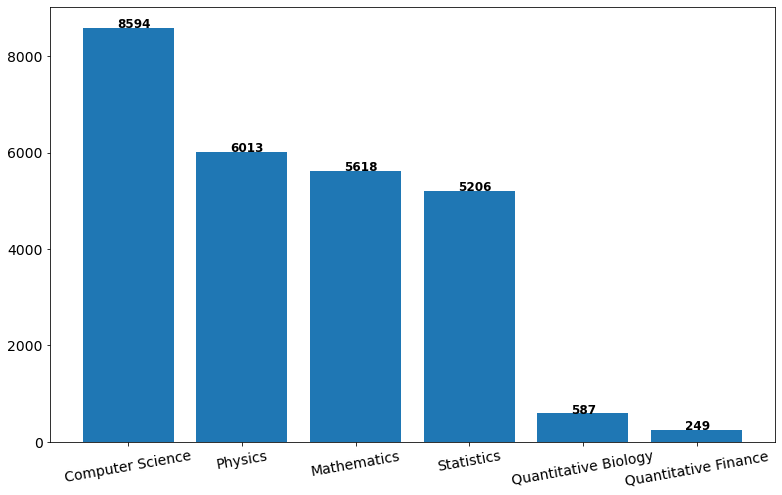

In [86]:
countOfTopics = df.iloc[:,2:].sum(axis=0)
plt.figure(figsize = (13,8))
plt.bar(countOfTopics.index, countOfTopics.values)
plt.xticks(rotation=10)

plt.rcParams.update({'font.size': 12})
xlocs, xlabs = plt.xticks()
xlocs=[i for i in range(0,6)]

for i, v in enumerate(countOfTopics.values):
    plt.text(xlocs[i] - 0.10, v + 0.01, str(v), fontweight='bold')

plt.savefig("../plots/countOfTopics.png")

In [87]:
# rows which has more than one topic
df[df.iloc[:,2:].sum(axis=1) > 1]

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
ID,,,,,,,,
5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
22,Many-Body Localization: Stability and Instability,Rare regions with weak disorder (Griffiths r...,0,1,1,0,0,0
29,Minimax Estimation of the $L_1$ Distance,We consider the problem of estimating the $L...,0,0,1,1,0,0
30,Density large deviations for multidimensional ...,We investigate the density large deviation f...,0,1,1,0,0,0
31,mixup: Beyond Empirical Risk Minimization,"Large deep neural networks are powerful, but...",1,0,0,1,0,0
...,...,...,...,...,...,...,...,...
20964,Faithful Inversion of Generative Models for Ef...,Inference amortization methods share informa...,1,0,0,1,0,0
20965,A social Network Analysis of the Operations Re...,We study the U.S. Operations Research/Indust...,1,0,0,1,0,0
20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0


In [88]:
# article which is considered both Physics and Mathematics
print(df.loc[22].TITLE,"\n")
print(df.loc[22].ABSTRACT)

Many-Body Localization: Stability and Instability 

  Rare regions with weak disorder (Griffiths regions) have the potential to
spoil localization. We describe a non-perturbative construction of local
integrals of motion (LIOMs) for a weakly interacting spin chain in one
dimension, under a physically reasonable assumption on the statistics of
eigenvalues. We discuss ideas about the situation in higher dimensions, where
one can no longer ensure that interactions involving the Griffiths regions are
much smaller than the typical energy-level spacing for such regions. We argue
that ergodicity is restored in dimension d > 1, although equilibration should
be extremely slow, similar to the dynamics of glasses.



* $5044$ out of $20972$ scientific articles have more than $1$ label.

In [89]:
# add title and abstract together
df["text"] = df["TITLE"] + df["ABSTRACT"]

In [90]:
# create the target variable
target_labels = ["Computer Science" ,"Physics" , "Mathematics", "Statistics" , "Quantitative Biology" , "Quantitative Finance"]
df['onehot_encoded'] = df[target_labels].values.tolist()

def get_topic(row):
    topics = []
    for label in target_labels:
        if row[label] == 1:
            topics.append(label)
    return ' & '.join(topics)

df["topic"] = df.apply(get_topic, axis=1)

# encode it by using LabelEncoder
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['topic'])

### Preprocessing

In [91]:
df.head(10)

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text,onehot_encoded,topic,label_encoded
ID,,,,,,,,,,,,
1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps P...,"[1, 0, 0, 0, 0, 0]",Computer Science,0
2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation i...,"[1, 0, 0, 0, 0, 0]",Computer Science,0
3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...,"[0, 0, 1, 0, 0, 0]",Mathematics,11
4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,A finite element approximation for the stochas...,"[0, 0, 1, 0, 0, 0]",Mathematics,11
5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...,"[1, 0, 0, 1, 0, 0]",Computer Science & Statistics,8
6,On maximizing the fundamental frequency of the...,Let $\Omega \subset \mathbb{R}^n$ be a bound...,0,0,1,0,0,0,On maximizing the fundamental frequency of the...,"[0, 0, 1, 0, 0, 0]",Mathematics,11
7,On the rotation period and shape of the hyperb...,We observed the newly discovered hyperbolic ...,0,1,0,0,0,0,On the rotation period and shape of the hyperb...,"[0, 1, 0, 0, 0, 0]",Physics,14
8,Adverse effects of polymer coating on heat tra...,The ability of metallic nanoparticles to sup...,0,1,0,0,0,0,Adverse effects of polymer coating on heat tra...,"[0, 1, 0, 0, 0, 0]",Physics,14
9,SPH calculations of Mars-scale collisions: the...,We model large-scale ($\approx$2000km) impac...,0,1,0,0,0,0,SPH calculations of Mars-scale collisions: the...,"[0, 1, 0, 0, 0, 0]",Physics,14


In [92]:
for topic, label in zip(df["topic"].unique(),df["label_encoded"].unique()):
    print("{:<55}:{:>10}".format(topic,label))
# 24 different labels, which means that 6 + 18 (combinations of different topics)    
print("Number of labels: ",len(df["label_encoded"].unique()))

Computer Science                                       :         0
Mathematics                                            :        11
Computer Science & Statistics                          :         8
Physics                                                :        14
Quantitative Biology                                   :        18
Statistics                                             :        21
Physics & Mathematics                                  :        15
Mathematics & Statistics                               :        12
Computer Science & Mathematics                         :         1
Quantitative Finance                                   :        20
Computer Science & Physics                             :         3
Computer Science & Mathematics & Statistics            :         2
Physics & Statistics                                   :        17
Computer Science & Physics & Statistics                :         5
Computer Science & Quantitative Biology                :      

In [93]:
df["topic"].value_counts()

Physics                                                 5120
Computer Science                                        4910
Mathematics                                             3610
Computer Science & Statistics                           2285
Statistics                                              1636
Mathematics & Statistics                                 825
Computer Science & Mathematics                           682
Quantitative Biology                                     443
Computer Science & Physics                               437
Physics & Mathematics                                    293
Quantitative Finance                                     209
Computer Science & Mathematics & Statistics              179
Statistics & Quantitative Biology                        105
Physics & Statistics                                      99
Computer Science & Physics & Statistics                   36
Computer Science & Quantitative Biology                   30
Statistics & Quantitativ

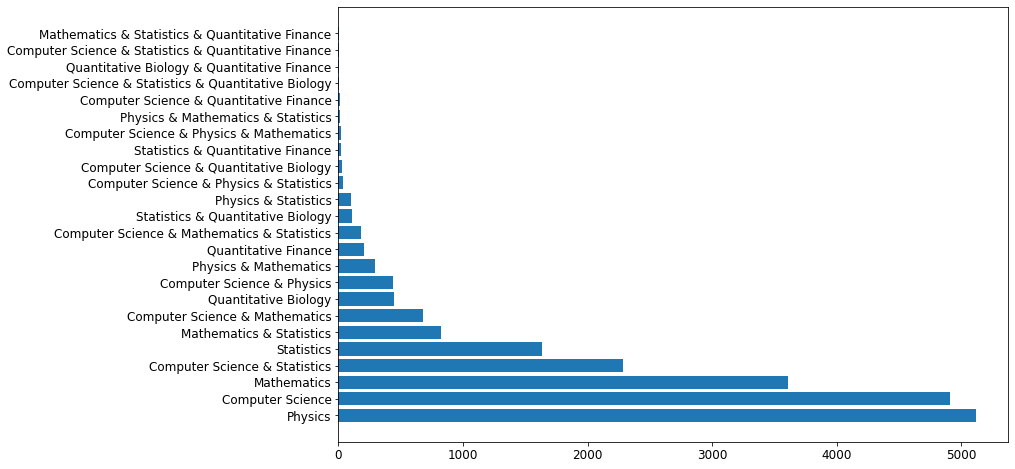

In [94]:
tags = df["topic"].value_counts().index
counts = df["topic"].value_counts().values

plt.figure(figsize = (12,8))
plt.tight_layout()
plt.barh(tags,counts)
plt.savefig("../plots/CountOfCombinedTopic.png",bbox_inches='tight');

In [95]:
# preprocessing
def clean_text(text):
    
    text = text.replace("\n"," ")     # replace "\n" with " "
    text = text.replace("\\n"," ")     # replace "\n" with " "
    text = text.replace("-"," ")       # replace "-" with " "
    text = text.lower()
    # remove numbers
    text = re.sub(r"[0-9]","",text)
    # replace mathematical expressions (like $\omega$ ...) to mathexpr
    text = re.sub(r"\$(.*?)\$","mathexpr", text)  
    text = re.sub(r"\$$(.*?)\$$","mathexpr", text) 
    text = re.sub(r"\\+begin{equation}(.*?)\\end{equation}","mathexpr",text)
    text = re.sub(r"\\+begin{equation\*}(.*?)\\end{equation\*}","mathexpr",text)
    text = re.sub(r"\\+begin{align}(.*?)\\end{align}","mathexpr",text)
    text = re.sub(r"\\+begin{align\*}(.*?)\\end{align\*}","mathexpr",text)
    
    # realize that there are many neural networks in articles so it could be useful to combine those two words
    text = text.replace("neural network","neuralnetwork")
    
    text = re.sub(r"\\[a-zA-z0-9]+{[a-zA-z0-9 ]+}","",text) # remove latex tags like \\textcolor{red}..
    text = re.sub(r"\\[a-zA-z0-9]+","",text) # remove everything starts with \\
    text = re.sub(r"[;%#'()_:=+,.*|~^<>!@{}/?\"\[\]\[\\]","",text) # remove punc and artifacts
    

    # reduce text to lexicon entry
    lemmas = [token.lemma_ for token in nlp(text)
              # keep only nouns, verbs, adjectives, adverbs and proper nouns
              if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN'}]
    
    return ' '.join(lemmas)

In [96]:
%%time
df["clean_text"] = df["text"].apply(clean_text)
df["clean_text"].head()

CPU times: user 3min 3s, sys: 0 ns, total: 3min 3s
Wall time: 3min 3s


ID
1    reconstruct subject specific effect map predic...
2    rotation invariance neuralnetwork rotation inv...
3    spherical polyharmonic poisson kernel polyharm...
4    finite element approximation stochastic maxwel...
5    comparative study discrete wavelet transform w...
Name: clean_text, dtype: object

In [97]:
print(df.text[6],"\n")
print(df.clean_text[6])

On maximizing the fundamental frequency of the complement of an obstacle  Let $\Omega \subset \mathbb{R}^n$ be a bounded domain satisfying a
Hayman-type asymmetry condition, and let $ D $ be an arbitrary bounded domain
referred to as "obstacle". We are interested in the behaviour of the first
Dirichlet eigenvalue $ \lambda_1(\Omega \setminus (x+D)) $. First, we prove an
upper bound on $ \lambda_1(\Omega \setminus (x+D)) $ in terms of the distance
of the set $ x+D $ to the set of maximum points $ x_0 $ of the first Dirichlet
ground state $ \phi_{\lambda_1} > 0 $ of $ \Omega $. In short, a direct
corollary is that if \begin{equation} \mu_\Omega := \max_{x}\lambda_1(\Omega
\setminus (x+D)) \end{equation} is large enough in terms of $ \lambda_1(\Omega)
$, then all maximizer sets $ x+D $ of $ \mu_\Omega $ are close to each maximum
point $ x_0 $ of $ \phi_{\lambda_1} $.
Second, we discuss the distribution of $ \phi_{\lambda_1(\Omega)} $ and the
possibility to inscribe wavelength balls at a g

In [98]:
stopwords = set(STOPWORDS) # this is taken by wordcloud library

def plotWordCloud(df : pd.DataFrame, ax, column : str):
    """Given the dataframe, matplotlib Axes object and target column plot the wordcloud"""
    
    df_filtered = df[df[column] == 1]
    texts = df_filtered["clean_text"].values
    text_all = " ".join(text for text in texts)
    
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_all)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(column)
    ax.axis("off")

CPU times: user 15.4 s, sys: 245 ms, total: 15.7 s
Wall time: 15.7 s


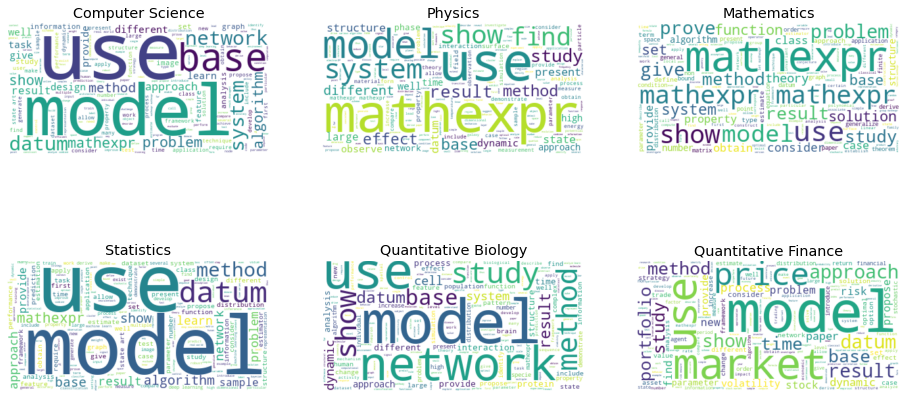

In [99]:
%%time
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3,figsize=(16,8))
for ax,topic in zip((ax1, ax2, ax3, ax4, ax5, ax6),target_labels):
    plotWordCloud(df,ax,topic)
plt.savefig("../plots/wordclouds.png")

In [100]:
from collections import Counter
counter = Counter(word for text in df["clean_text"].values for word in text.split() if not word in nlp.Defaults.stop_words)
counter_dict = dict(counter.most_common(40))
counter.most_common(20)

[('mathexpr', 30595),
 ('datum', 10400),
 ('system', 10190),
 ('time', 8660),
 ('algorithm', 8627),
 ('network', 8374),
 ('function', 6482),
 ('state', 6467),
 ('high', 6189),
 ('present', 5817),
 ('new', 5443),
 ('large', 5437),
 ('learn', 5411),
 ('set', 5180),
 ('analysis', 5136),
 ('number', 5011),
 ('structure', 4946),
 ('space', 4926),
 ('field', 4886),
 ('order', 4770)]

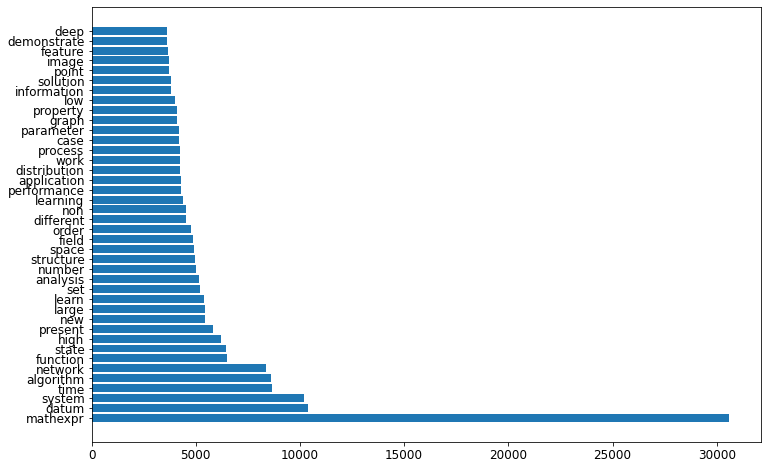

In [101]:
plt.figure(figsize = (12,8))
plt.barh(list(counter_dict.keys()),list(counter_dict.values()))
plt.savefig("../plots/commonWords.png");

In [102]:
def print_most_commons(counter : Counter):
    for word,count in counter:
        print("{:<15}:{:>10}".format(word,count))

common_word_list = []
for topic in target_labels:
    print("\nMost common 10 words and their counts for topic \033[1m{}\033[0m:".format(topic))
    df_filtered = df[df[topic] == 1]
    counter = Counter(word for text in df_filtered["clean_text"].values for word in text.split() if not word in nlp.Defaults.stop_words)
    common_word_list.append(list(dict(counter.most_common(10)).keys()))
    print_most_commons(counter.most_common(10))


Most common 10 words and their counts for topic Computer Science:
mathexpr       :      6871
algorithm      :      6205
network        :      6074
datum          :      5755
system         :      5213
time           :      4343
learn          :      4186
learning       :      3225
performance    :      2981
graph          :      2924

Most common 10 words and their counts for topic Physics:
mathexpr       :      7590
system         :      3511
field          :      3054
state          :      2744
high           :      2688
time           :      2571
energy         :      2413
phase          :      2358
spin           :      2030
present        :      1955

Most common 10 words and their counts for topic Mathematics:
mathexpr       :     17479
function       :      2635
space          :      2232
group          :      2180
prove          :      1931
equation       :      1901
system         :      1727
set            :      1692
solution       :      1617
number         :      1481

Mo

In [103]:
# flatten the list
common_word_list_flat = [word for word_list in common_word_list for word in word_list]
#create counter object particular topic
common_word_counter = Counter(common_word_list_flat)
common_word_counter.most_common(10)
# here we can consider use, model, method and result as a field specific stopwords

[('time', 5),
 ('mathexpr', 4),
 ('datum', 4),
 ('system', 4),
 ('network', 3),
 ('algorithm', 2),
 ('learn', 2),
 ('learning', 2),
 ('state', 2),
 ('performance', 1)]

In [104]:
# update the stop words
nlp.Defaults.stop_words |= {"use","model","method","result","study", "paper"}
nlp.Defaults.stop_words |= {"base","approach","find","problem","provide","propose"} # intiaution
stop_words = set(nlp.Defaults.stop_words)

def remove_stopwords(text):
    # remove stopwords
    tokens = [token.text for token in nlp(text) if token.text not in stop_words]
    return ' '.join(tokens)         

In [105]:
%%time
df["clean_text"] = df["clean_text"].apply(remove_stopwords)
df["clean_text"].head()

CPU times: user 1min 59s, sys: 0 ns, total: 1min 59s
Wall time: 1min 59s


ID
1    reconstruct subject specific effect map predic...
2    rotation invariance neuralnetwork rotation inv...
3    spherical polyharmonic poisson kernel polyharm...
4    finite element approximation stochastic maxwel...
5    comparative discrete wavelet transform wavelet...
Name: clean_text, dtype: object

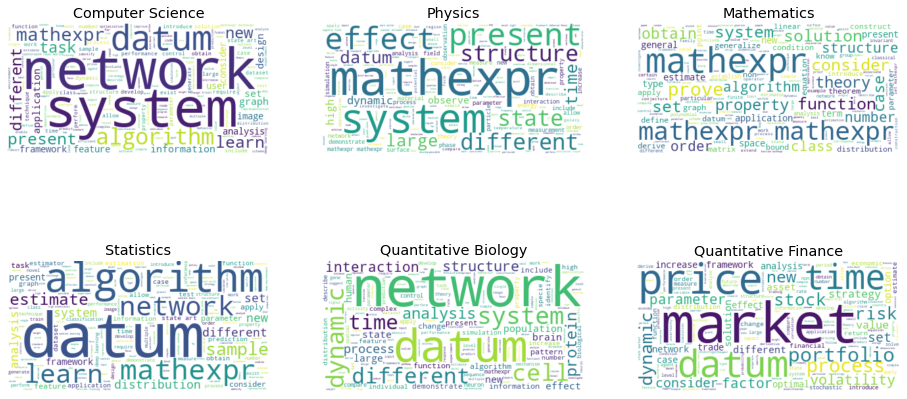

In [106]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3,figsize=(16,8))
for ax,topic in zip((ax1, ax2, ax3, ax4, ax5, ax6),target_labels):
    plotWordCloud(df,ax,topic)
plt.savefig("../plots/wordcloudsStopWordsRemoved.png")

In [107]:
# save the clean data
df.to_excel("../data/clean_train.xlsx",index_label="ID")

In [108]:
# split the data
target_topics = list(df.columns[2:8].values)
# split data to have all labels in both train and test set
def split_data(df, train_percentage): # 
    train_idx = []
    
    for topic in target_topics:
        df_filtered = df[df[topic] == 1]
        split_idx = int(len(df_filtered) * train_percentage)       
        indexes = df[df[topic] == 1].index[:split_idx]
        train_idx.append(list(indexes.values))
        
    flat_list_idx = [item for sublist in train_idx for item in sublist]
    train_df = df.loc[list(set(flat_list_idx))]
    test_idx = list(set(df.index.to_list()).difference(set(flat_list_idx)))  
    test_df = df.loc[test_idx]
    print("Shape of train dataframe {} and shape of test_df {}".format(train_df.shape, test_df.shape))
    return train_df, test_df

In [109]:
# these splitted data will be used later for classification report, since it's common
# for both methods (MultiOutput and Chain) it is run here
train_data, test_data = split_data(df.sample(frac=1,axis=0,random_state=42), 0.8) # give shuffled data

Shape of train dataframe (16790, 13) and shape of test_df (4182, 13)


### MultiOutputClassifier

After analyzing the topic columns, it is obvious to realize that some papers has more than one label. This problem is known as [multi-label classification](https://scikit-learn.org/stable/modules/multiclass.html). It can be solved by [sklearn](https://scikit-learn.org/stable/) library.

In [110]:
%%time
# transform texts into a matrix
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.75, 
                             stop_words='english')

X = vectorizer.fit_transform(df['clean_text'])
print(X.shape)

(20972, 8459)
CPU times: user 4.1 s, sys: 84.1 ms, total: 4.19 s
Wall time: 4.18 s


In [111]:
# convert target variable to np.arrays
y = np.array([np.array(l) for l in df["onehot_encoded"].values])
print(y.shape)

(20972, 6)


Below approach is unable to detect the correlation among the classes

In [112]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

In [113]:
classifier = LogisticRegression(n_jobs=-1, class_weight='balanced')
multi_target = MultiOutputClassifier(classifier, n_jobs=-1)
multi_target.fit(X, y)

MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   n_jobs=-1),
                      n_jobs=-1)

#### Interpret the Result of Multi Output Classifier

In [114]:
target_classifier = dict(zip(target_labels,multi_target.estimators_))

In [115]:
def printCoefOfWord(word,classifiers):
    """ Given the word print the coefficient of word for each classifier"""
    position = vectorizer.vocabulary_[word]
    for target in target_classifier:
        print("{:<25}:{:>10.2f}".format(target,classifiers.get(target).coef_[0, position]))

In [116]:
wordsToCheck = ["mathexpr","distribution", "algorithm","neuralnetwork","cell","economy","velocity"]
for word in wordsToCheck:
    print("\033[1m{}\033[0m".format(word))
    printCoefOfWord(word,target_classifier)
    print("\n")

mathexpr
Computer Science         :     -1.05
Physics                  :     -1.27
Mathematics              :      2.13
Statistics               :     -1.21
Quantitative Biology     :     -2.90
Quantitative Finance     :     -3.52


distribution
Computer Science         :     -0.54
Physics                  :     -0.30
Mathematics              :      0.52
Statistics               :      3.80
Quantitative Biology     :      1.16
Quantitative Finance     :     -0.09


algorithm
Computer Science         :      3.65
Physics                  :     -3.00
Mathematics              :     -1.39
Statistics               :      2.07
Quantitative Biology     :     -0.65
Quantitative Finance     :     -1.28


neuralnetwork
Computer Science         :      1.62
Physics                  :     -2.01
Mathematics              :     -3.74
Statistics               :      4.50
Quantitative Biology     :     -0.61
Quantitative Finance     :      0.28


cell
Computer Science         :     -1.29
Physics         

#### Evaluation of the Model

To evaluate the performance of the model, 5 metrics will be used. Precision, recall, F1 and accuracy (custom function is written) and exact match ratio (accuracy in sklearn). Those metrics will be estimated by using 5 fold cross validation.

**Explain the average strategy to continue**

In [117]:
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.metrics import make_scorer

In [118]:
def printAvgOfMetrics(cvResults):
    print("*"*32)
    for metric in cvResults:
        if metric != "fit_time" and metric != "score_time":
            print("{:<20}:{:>10}".format(metric,round(np.mean(cv_results.get(metric)),3)))
    print("*"*32)

In [119]:
def accuracy(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]

acc = make_scorer(accuracy)

In [120]:
from sklearn.metrics import f1_score, accuracy_score,precision_score,recall_score

def printTestMetrics(y_true,y_pred):
    print("Accuracy: {:.3f}\nEMR: {:.3f}\nF1_Macro: {:.3f}\nPrecision_Macro: {:.3f}\nRecall_Macro: {:.3f}".
          format((accuracy(y_true, y_pred)),accuracy_score(y_true, y_pred),
                f1_score(y_true, y_pred, average='macro'),
                 precision_score(y_true, y_pred, average='macro'),
                 recall_score(y_true, y_pred, average='macro')))

In [121]:
for k in [2,3,5,10]:
    cv_results = cross_validate(multi_target, X, y, cv=k, n_jobs=-1,
                            scoring=({"accuracy" : acc, "emr":"accuracy",
                                      "precision":"precision_macro",
                                      "recall":"recall_macro","f1":"f1_macro"}))
    fold_size = X.shape[0]/k
    print("Result of \033[1mk = {}\033[0m:".format(k))
    printAvgOfMetrics(cv_results)
    print("Training on {} instances/fold, testing on {}\n".format(int(fold_size*(k-1)), int(fold_size)))

Result of k = 2:
********************************
test_accuracy       :     0.779
test_emr            :      0.63
test_precision      :     0.683
test_recall         :     0.806
test_f1             :     0.735
********************************
Training on 10486 instances/fold, testing on 10486

Result of k = 3:
********************************
test_accuracy       :     0.782
test_emr            :     0.631
test_precision      :     0.678
test_recall         :     0.817
test_f1             :     0.736
********************************
Training on 13981 instances/fold, testing on 6990

Result of k = 5:
********************************
test_accuracy       :     0.783
test_emr            :     0.631
test_precision      :     0.675
test_recall         :     0.827
test_f1             :     0.736
********************************
Training on 16777 instances/fold, testing on 4194

Result of k = 10:
********************************
test_accuracy       :     0.785
test_emr            :     0.633
te

In [122]:
# choose the best regularizaiton parameter by using cv
best_c = None
best_f1_score = 0.0

for c in [50, 20, 10, 1.0, 0.5, 0.1, 0.05, 0.01]:
    classifier = LogisticRegression(C = c, n_jobs=-1, class_weight='balanced')
    multi_target = MultiOutputClassifier(classifier, n_jobs=-1)
    cv_reg = cross_val_score(multi_target, X, y=y, cv=5, n_jobs=-1, scoring="f1_macro").mean()

    print("5-CV on train at C={}: {}".format(c, cv_reg.mean()))

    if cv_reg > best_f1_score:
        best_f1_score = cv_reg
        best_c = c
        
print("best C parameter: {}".format(best_c))

5-CV on train at C=50: 0.7146724489711508
5-CV on train at C=20: 0.7300582764374107
5-CV on train at C=10: 0.7363260728230101
5-CV on train at C=1.0: 0.7362944622560038
5-CV on train at C=0.5: 0.7302696633153728
5-CV on train at C=0.1: 0.7145765927358819
5-CV on train at C=0.05: 0.7060223466768212
5-CV on train at C=0.01: 0.6903183052018972
best C parameter: 10


In [123]:
# select the best features to have better performance
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [124]:
numFeatures = np.linspace(1000, X.shape[1],10)
bestNofFeatures = None
best_f1_score = 0.0
for n_feat in numFeatures:
    # select features
    selector = SelectKBest(chi2, k=int(n_feat)).fit(X, y)
    X_sel = selector.transform(X)
    # calculate the f1
    classifier = LogisticRegression(C = best_c, n_jobs=-1, class_weight='balanced')
    multi_target = MultiOutputClassifier(classifier, n_jobs=-1)
    cv_reg = cross_val_score(multi_target, X_sel, y=y, cv=5, n_jobs=-1, scoring="f1_macro").mean()
    
    if cv_reg > best_f1_score:
        best_f1_score = cv_reg
        bestNofFeatures = X_sel.shape[1]   
   
    print("Selected number of features {}, 5-CV on train: {}".format(X_sel.shape[1],cv_reg.mean()))
    
print("best number of features : {}".format(bestNofFeatures))

Selected number of features 1000, 5-CV on train: 0.6958692011739871
Selected number of features 1828, 5-CV on train: 0.7158055824195804
Selected number of features 2657, 5-CV on train: 0.7238484765723614
Selected number of features 3486, 5-CV on train: 0.7310275465688715
Selected number of features 4315, 5-CV on train: 0.7313923495964262
Selected number of features 5143, 5-CV on train: 0.7352469161194037
Selected number of features 5972, 5-CV on train: 0.7393997501914537
Selected number of features 6801, 5-CV on train: 0.7376653504960898
Selected number of features 7630, 5-CV on train: 0.7356630532874677
Selected number of features 8459, 5-CV on train: 0.7363260728230101
best number of features : 5972


In [125]:
# getting insights
features = vectorizer.get_feature_names() # get the names of the features
top_scores = selector.scores_.argsort()[-8459:] # get the indices of the selection
best_indicator_terms = [features[i] for i in sorted(top_scores)] # sort feature names

# get for each classifiers
df_indicator = pd.DataFrame(data = {'feature': best_indicator_terms})
for classifier in target_classifier:
    col_name = classifier + "_coefficient"
    df_indicator[col_name] = target_classifier.get(classifier).coef_[0]

In [126]:
df_indicator.sort_values('Physics_coefficient',ascending=False).head(20)

,feature,Computer Science_coefficient,Physics_coefficient,Mathematics_coefficient,Statistics_coefficient,Quantitative Biology_coefficient,Quantitative Finance_coefficient
7284,spin,-2.526545,4.278774,-2.445357,-1.743028,-1.900700,-0.957594
4486,material,-1.802552,3.990972,-0.943542,-1.277334,-1.371746,-1.008546
5754,physics,-0.919736,3.933906,-1.031227,-1.151151,-0.474997,0.372913
844,calculation,-1.837625,3.888684,-1.973534,-0.428066,-0.666153,-0.103836
3069,galaxy,-2.736271,3.874117,-2.331557,-1.920973,-1.200126,-0.830263
7338,star,-2.838015,3.842382,-2.082002,-1.873741,-1.943005,-1.018572
2297,electron,-2.684455,3.779550,-2.593768,-1.601186,-0.281101,-0.990024
5426,optical,-1.726264,3.557837,-2.050827,-1.957063,-1.802526,-0.851635
7695,temperature,-2.330765,3.515187,-2.614101,-1.295251,-1.702805,-1.477841
3806,integrable,-1.538806,3.365127,-0.226116,-0.621430,-0.550272,-0.425525


In [127]:
def plotDescriptiveWords(df , topic, ax):
    df[["feature",topic+"_coefficient"]].sort_values(topic+"_coefficient",ascending=False)[:10].plot(x="feature",y = topic+"_coefficient"
                                                                                                    ,kind="bar",title = "Descriptive Words of " + topic
                                                                                                    ,legend=False, xlabel = "Words", ylabel = "Coefficients"
                                                                                                    ,rot=20, ax = ax,fontsize=13.5);

CPU times: user 1.14 s, sys: 40.3 ms, total: 1.18 s
Wall time: 1.18 s


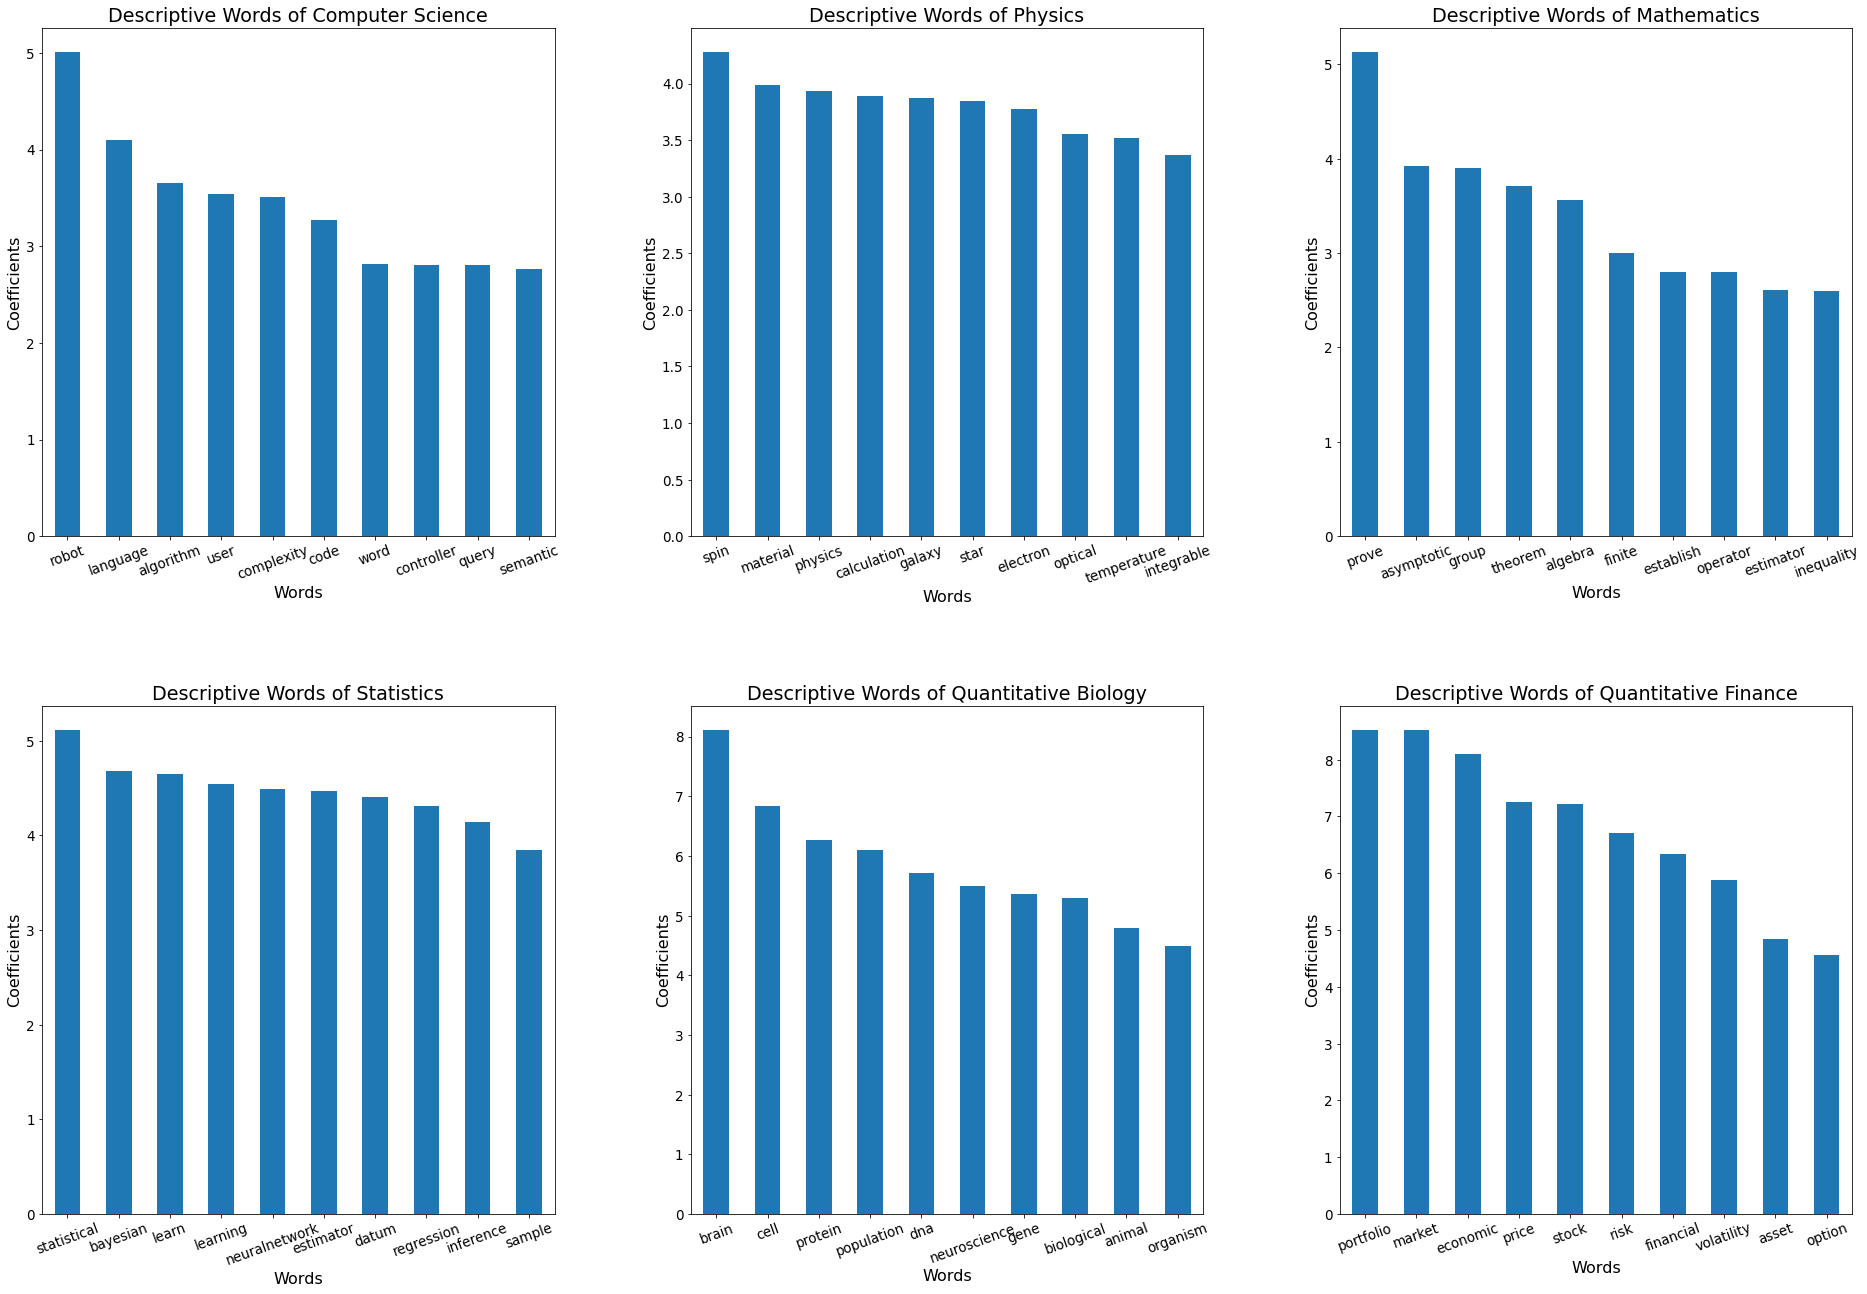

In [128]:
%%time
plt.rcParams.update({'font.size': 16})
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3,figsize=(28,20))
for ax,topic in zip((ax1, ax2, ax3, ax4, ax5, ax6),target_labels):
    plotDescriptiveWords(df_indicator,topic,ax)
fig.tight_layout(pad=5)
plt.savefig("../plots/descriptiveWords.png")

In [129]:
# train the model with splitted data and check the classificaiton report on unseen data

vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.75, 
                             stop_words='english')

X_train = vectorizer.fit_transform(train_data['clean_text'])
X_test = vectorizer.transform(test_data['clean_text'])

y_train = np.array([np.array(l) for l in train_data["onehot_encoded"].values])
y_test = np.array([np.array(l) for l in test_data["onehot_encoded"].values])

In [130]:
classifier = LogisticRegression(n_jobs=-1, class_weight='balanced')
multi_target = MultiOutputClassifier(classifier, n_jobs=-1)
multi_target.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   n_jobs=-1),
                      n_jobs=-1)

In [131]:
y_pred = multi_target.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_labels,zero_division=1))

                      precision    recall  f1-score   support

    Computer Science       0.81      0.88      0.85      1719
             Physics       0.88      0.89      0.88      1202
         Mathematics       0.74      0.87      0.80      1110
          Statistics       0.72      0.87      0.79      1032
Quantitative Biology       0.40      0.69      0.50       118
Quantitative Finance       0.52      0.66      0.58        50

           micro avg       0.77      0.87      0.82      5231
           macro avg       0.68      0.81      0.73      5231
        weighted avg       0.78      0.87      0.82      5231
         samples avg       0.83      0.90      0.84      5231



In [132]:
printTestMetrics(y_test, y_pred)

Accuracy: 0.784
EMR: 0.633
F1_Macro: 0.734
Precision_Macro: 0.679
Recall_Macro: 0.809


### Chain Classifier

Another approach to solve the multi label classification problems is using classifier chains. With this method we will be able to preserve the label correlation.

In [133]:
%%time

vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.75, 
                             stop_words='english')

X = vectorizer.fit_transform(df['clean_text'])
print(X.shape)

(20972, 8459)
CPU times: user 3.8 s, sys: 92.1 ms, total: 3.89 s
Wall time: 3.89 s


In [134]:
# convert target variable to np.arrays
y = np.array([np.array(l) for l in df["onehot_encoded"].values])
print(y.shape)

(20972, 6)


In [135]:
from sklearn.multioutput import ClassifierChain

classifier = LogisticRegression(n_jobs=-1, class_weight='balanced')
chain = ClassifierChain(classifier)
chain.fit(X, y)

ClassifierChain(base_estimator=LogisticRegression(class_weight='balanced',
                                                  n_jobs=-1))

In [136]:
chain_classifiers = dict(zip(target_labels,chain.estimators_))

In [137]:
wordsToCheck = ["mathexpr", "prove", "algorithm","cell","neuralnetwork","economy","velocity"]
for word in wordsToCheck:
    print("\033[1m{}\033[0m".format(word))
    printCoefOfWord(word,chain_classifiers)
    print("\n")

mathexpr
Computer Science         :     -1.05
Physics                  :     -1.59
Mathematics              :      2.04
Statistics               :     -1.20
Quantitative Biology     :     -1.91
Quantitative Finance     :     -2.17


prove
Computer Science         :     -1.10
Physics                  :     -4.40
Mathematics              :      3.97
Statistics               :     -1.61
Quantitative Biology     :     -0.78
Quantitative Finance     :     -0.73


algorithm
Computer Science         :      3.65
Physics                  :     -2.27
Mathematics              :     -1.07
Statistics               :      1.91
Quantitative Biology     :      0.41
Quantitative Finance     :     -0.43


cell
Computer Science         :     -1.29
Physics                  :     -1.46
Mathematics              :     -1.81
Statistics               :     -2.30
Quantitative Biology     :      3.45
Quantitative Finance     :     -1.13


neuralnetwork
Computer Science         :      1.62
Physics                

In [138]:
for k in [2,3,5,10]:
    cv_results = cross_validate(chain, X, y, cv=k, n_jobs=-1,
                                scoring=({"accuracy" : acc, "emr":"accuracy",
                                          "precision":"precision_macro",
                                          "recall":"recall_macro","f1":"f1_macro"}))
    fold_size = X.shape[0]/k
    print("Result of \033[1mk = {}\033[0m:".format(k))
    printAvgOfMetrics(cv_results)
    print("Training on {} instances/fold, testing on {}\n".format(int(fold_size*(k-1)), int(fold_size)))

Result of k = 2:
********************************
test_accuracy       :     0.778
test_emr            :     0.651
test_precision      :     0.696
test_recall         :     0.646
test_f1             :     0.653
********************************
Training on 10486 instances/fold, testing on 10486

Result of k = 3:
********************************
test_accuracy       :     0.783
test_emr            :     0.655
test_precision      :     0.705
test_recall         :     0.666
test_f1             :     0.673
********************************
Training on 13981 instances/fold, testing on 6990

Result of k = 5:
********************************
test_accuracy       :     0.786
test_emr            :     0.659
test_precision      :     0.711
test_recall         :     0.678
test_f1             :     0.682
********************************
Training on 16777 instances/fold, testing on 4194

Result of k = 10:
********************************
test_accuracy       :     0.788
test_emr            :     0.659
te

In [139]:
# choose the best regularizaiton parameter by using cv

best_c = None
best_f1_score = 0.0

for c in [50, 20, 10, 1.0, 0.5, 0.1, 0.05, 0.01]:
    classifier = LogisticRegression(C = c, n_jobs=-1, class_weight='balanced')
    chain = ClassifierChain(classifier)
    cv_reg = cross_val_score(chain, X, y=y, cv=5, n_jobs=-1, scoring="f1_macro").mean()

    print("5-CV on train at C={}: {}".format(c, cv_reg.mean()))

    if cv_reg > best_f1_score:
        best_f1_score = cv_reg
        best_c = c
        
print("best C parameter: {}".format(best_c))

5-CV on train at C=50: 0.6660241094458245
5-CV on train at C=20: 0.6804000534585942
5-CV on train at C=10: 0.6908494403738193
5-CV on train at C=1.0: 0.6822310203058202
5-CV on train at C=0.5: 0.6587949094652178
5-CV on train at C=0.1: 0.555012432922474
5-CV on train at C=0.05: 0.5083249334869859
5-CV on train at C=0.01: 0.35139653971708024
best C parameter: 10


In [140]:
numFeatures = np.linspace(1000, X.shape[1],10)
bestNofFeatures = None
best_f1_score = 0.0
for n_feat in numFeatures:
    # select features
    selector = SelectKBest(chi2, k=int(n_feat)).fit(X, y)
    X_sel = selector.transform(X)
    # calculate the f1
    classifier = LogisticRegression(C = best_c, n_jobs=-1, class_weight='balanced')
    chain = ClassifierChain(classifier)
    cv_reg = cross_val_score(chain, X_sel, y=y, cv=5, n_jobs=-1, scoring="f1_macro").mean()
    
    if cv_reg > best_f1_score:
        best_f1_score = cv_reg
        bestNofFeatures = X_sel.shape[1]   
        
    print("Selected number of features {}, 5-CV on train: {}".format(X_sel.shape[1],cv_reg.mean()))
    
print("best number of features : {}".format(bestNofFeatures))

Selected number of features 1000, 5-CV on train: 0.6892831085259468
Selected number of features 1828, 5-CV on train: 0.6940518698286275
Selected number of features 2657, 5-CV on train: 0.6978855276185905
Selected number of features 3486, 5-CV on train: 0.6964704077350423
Selected number of features 4315, 5-CV on train: 0.6969402426851729
Selected number of features 5143, 5-CV on train: 0.6943854330882574
Selected number of features 5972, 5-CV on train: 0.6877225889867623
Selected number of features 6801, 5-CV on train: 0.6928860213486626
Selected number of features 7630, 5-CV on train: 0.693666660614642
Selected number of features 8459, 5-CV on train: 0.6908494403738193
best number of features : 2657


In [141]:
# getting insights
features = vectorizer.get_feature_names() # get the names of the features
top_scores = selector.scores_.argsort()[-8459:] # get the indices of the selection
best_indicator_terms = [features[i] for i in sorted(top_scores)] # sort feature names

# get for each classifiers
df_indicator = pd.DataFrame(data = {'feature': best_indicator_terms})
for classifier in chain_classifiers:
    col_name = classifier + "_coefficient"
    print(chain_classifiers.get(classifier).coef_[0][8459:])
    df_indicator[col_name] = chain_classifiers.get(classifier).coef_[0][:8459]

[]
[-1.38344634]
[-1.66637787 -2.55611428]
[-1.32664977 -2.6077221  -1.04349865]
[-5.19073427 -8.72428543 -7.45435219 -3.29873318]
[-6.14066071 -8.4091421  -7.15283177 -4.51800471 -4.78312178]


In [142]:
df_indicator.sort_values('Computer Science_coefficient',ascending=False).head(20)

,feature,Computer Science_coefficient,Physics_coefficient,Mathematics_coefficient,Statistics_coefficient,Quantitative Biology_coefficient,Quantitative Finance_coefficient
6685,robot,5.008816,-1.987768,-1.850972,-1.345129,-0.732638,-0.692761
4045,language,4.100310,-0.845383,-1.567051,-0.893818,-0.988971,-0.870534
201,algorithm,3.653128,-2.269708,-1.072530,1.906440,0.406436,-0.430079
8172,user,3.536527,-0.865375,-1.143679,-0.848492,-1.837275,-1.761362
1208,complexity,3.513924,-0.903877,-0.633589,0.339764,-0.502733,-0.376039
1075,code,3.274290,-0.003932,0.350369,-0.690009,-0.983476,-0.589152
8406,word,2.816885,-0.326257,-0.535053,-0.275680,-0.736279,-0.531736
1434,controller,2.801976,-0.667009,0.229932,-1.938753,-0.048589,-0.325093
6242,query,2.801550,-1.221270,-1.375880,-0.740888,-0.800067,-0.446976
6863,semantic,2.763416,-1.537305,-0.198925,-0.909442,-0.797631,-0.418282


CPU times: user 846 ms, sys: 44.2 ms, total: 890 ms
Wall time: 889 ms


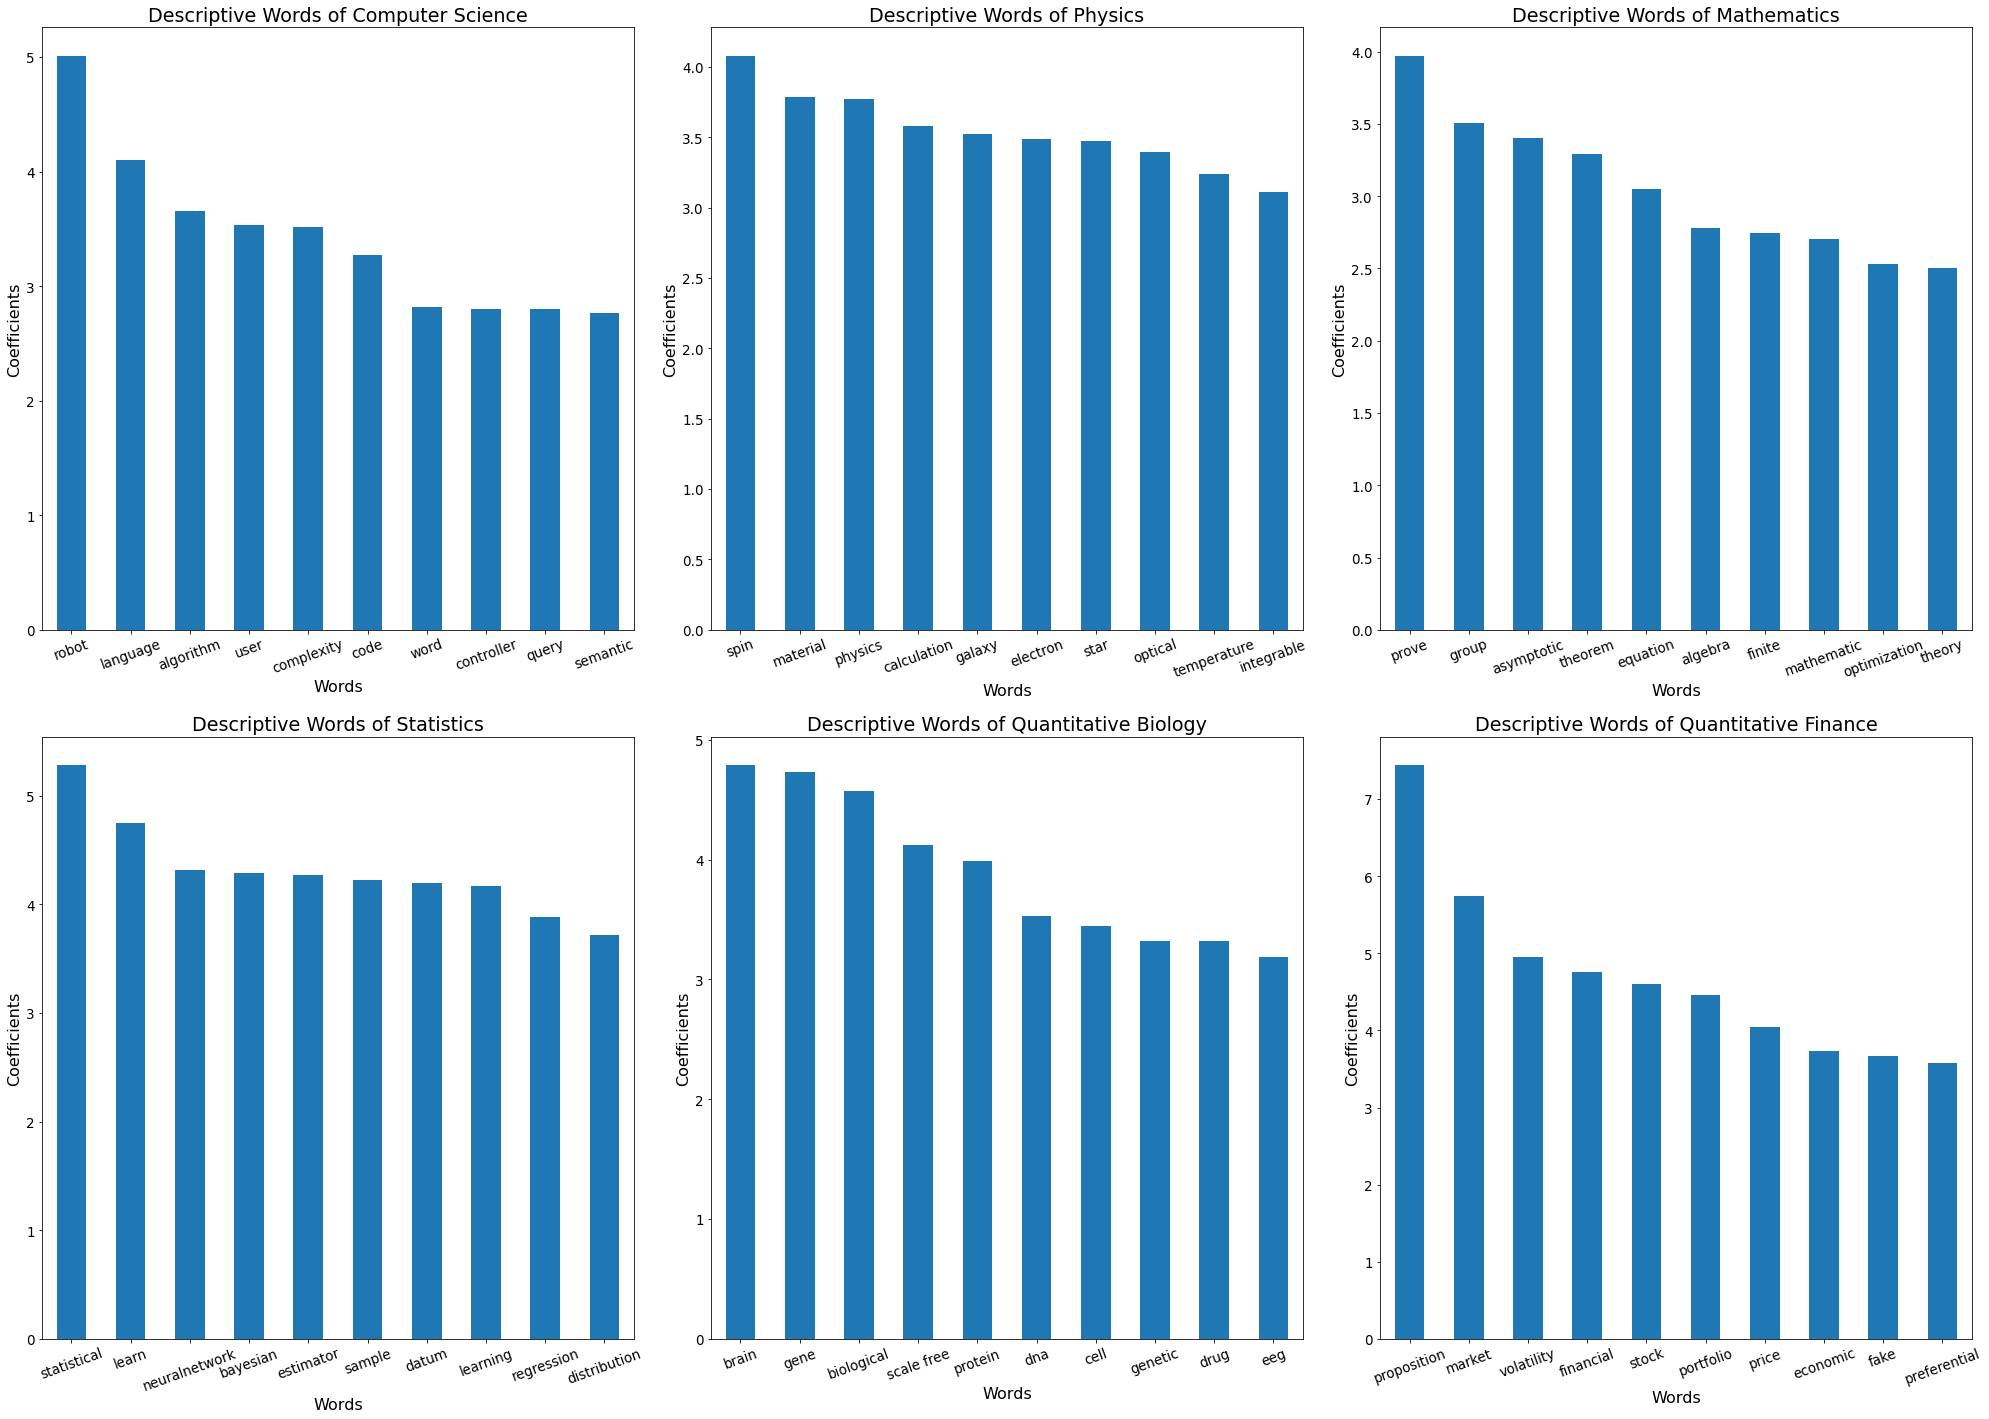

In [143]:
%%time
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3,figsize=(28,20))
for ax,topic in zip((ax1, ax2, ax3, ax4, ax5, ax6),target_labels):
    plotDescriptiveWords(df_indicator,topic,ax)
fig.tight_layout()
plt.savefig("../plots/chainDescriptiveWords.png")

In [144]:
classifier = LogisticRegression(n_jobs=-1, class_weight='balanced')
chain = ClassifierChain(classifier)
chain.fit(X_train, y_train)

ClassifierChain(base_estimator=LogisticRegression(class_weight='balanced',
                                                  n_jobs=-1))

In [145]:
y_pred = chain.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_labels,zero_division=1))

                      precision    recall  f1-score   support

    Computer Science       0.81      0.88      0.85      1719
             Physics       0.88      0.88      0.88      1202
         Mathematics       0.77      0.83      0.80      1110
          Statistics       0.72      0.85      0.78      1032
Quantitative Biology       0.43      0.25      0.31       118
Quantitative Finance       0.65      0.34      0.45        50

           micro avg       0.79      0.84      0.82      5231
           macro avg       0.71      0.67      0.68      5231
        weighted avg       0.79      0.84      0.81      5231
         samples avg       0.83      0.87      0.83      5231



In [146]:
printTestMetrics(y_test,y_pred)

Accuracy: 0.786
EMR: 0.659
F1_Macro: 0.677
Precision_Macro: 0.711
Recall_Macro: 0.671


### Deep Learning

#### Preprocess for Deep Learning

In [147]:
n_samples = len(train_data)
n_classes = len(target_labels)

weight_dict = {}
for idx, topic in enumerate(target_labels):
    n_samples_topic = len(train_data[train_data[topic] == 1])
    weight = n_samples / (n_classes * n_samples_topic)
    weight_dict[idx] = weight
weight_dict

{0: 0.407030303030303,
 1: 0.5816531559620315,
 2: 0.6207482993197279,
 3: 0.67042006069318,
 4: 5.966595593461265,
 5: 14.061976549413735}

In [148]:
target = "onehot_encoded"
input_column = "clean_text"

train_instances = train_data[input_column].apply(str).apply(str.split)
test_instances = test_data[input_column].apply(str).apply(str.split)

# collect known word tokens
wordset = set()

for words in train_instances:
    wordset.update(set(words))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words

def convert2ints(instances):
    result = []
    for words in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        result.append(word_ints)
    return result

train_instances_int = convert2ints(train_instances)
test_instances_int = convert2ints(test_instances)

# convert target column to numpy array
train_1hot = np.array([np.array(i) for i in train_data[target]])
test_1hot = np.array([np.array(i) for i in test_data[target]])

In [149]:
# compute 95th percentile of training sentence lengths
L = sorted(map(len, train_instances))
MAX_LENGTH = L[int(len(L)*0.95)]
print(MAX_LENGTH) # 95 percentile

# apply padding
from keras.preprocessing.sequence import pad_sequences
train_instances_int = pad_sequences(train_instances_int, padding='post', maxlen=MAX_LENGTH)
test_instances_int = pad_sequences(test_instances_int, padding='post', maxlen=MAX_LENGTH)

148


In [150]:
# set parameters of matrices and convolution
embedding_dim = 64
filter_length = 3

# batch size can have a huge effect on performance!
batch_size = 64
epochs = 5

In [151]:
def predict(model, test_data,threshold):
    y_pred = model.predict(test_data,batch_size=batch_size)
    y_pred = y_pred > threshold
    y_pred = y_pred.astype(int)
    return y_pred

#### CNN

In [152]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

filter_length = 300

model = Sequential()
model.add(Embedding(len(word2int), embedding_dim, input_length=MAX_LENGTH))
model.add(Dropout(0.1))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(6))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
model.summary()


history = model.fit(train_instances_int, train_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    class_weight = weight_dict
                   )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 148, 64)           2614464   
_________________________________________________________________
dropout_1 (Dropout)          (None, 148, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 146, 300)          57900     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1806      
_________________________________________________________________
activation_1 (Activation)    (None, 6)                 0         
Total params: 2,674,170
Trainable params: 2,674,170
Non-trainable params: 0
____________________________________________

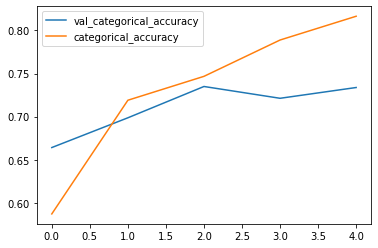

In [153]:
%matplotlib inline
df_result = pd.DataFrame(history.history)
df_result[['val_categorical_accuracy', 'categorical_accuracy']].plot.line();
#df_result[['val_loss', 'loss']].plot.line();
plt.savefig("../plots/epochVSAccuracy.png")

In [154]:
y_pred = predict(model,test_instances_int,0.5)
print(classification_report(test_1hot, y_pred, target_names=target_labels,zero_division=1))

                      precision    recall  f1-score   support

    Computer Science       0.85      0.76      0.81      1719
             Physics       0.91      0.83      0.87      1202
         Mathematics       0.80      0.80      0.80      1110
          Statistics       0.73      0.75      0.74      1032
Quantitative Biology       0.48      0.39      0.43       118
Quantitative Finance       0.59      0.60      0.59        50

           micro avg       0.82      0.77      0.80      5231
           macro avg       0.73      0.69      0.71      5231
        weighted avg       0.82      0.77      0.80      5231
         samples avg       0.86      0.81      0.79      5231



In [155]:
set(df.topic.unique()).difference(set(test_data.topic.unique()))

{'Computer Science & Statistics & Quantitative Finance',
 'Mathematics & Statistics & Quantitative Finance'}

In [156]:
printTestMetrics(test_1hot,y_pred)

Accuracy: 0.746
EMR: 0.627
F1_Macro: 0.707
Precision_Macro: 0.728
Recall_Macro: 0.690
